# AdventureWorks2022

### Beskrivning

Databasen AdventureWorks2022 är skapad utefter det fiktiva företaget Adventure Work Cycles.
Företaget tillverkar cyklar och cykeldelar till nordamerikanska, europeiska och australienska marknader.
Då räkenskapsåret varit framgångsrikt för företaget, ser de efter en möjlig utökning av marknadsandelar genom att fokusera på deras främsta kunder, utöka deras tillgänglighet för produkter genom webben, samt att reducera deras kostnader för tillverkning. Deras kunder består av både butiker och privatpersoner.

### Databasens innehåll
Databasen består kortfattat utav företagets personal med respektive avdelningar, tillverkning och produkter samt försäljningsordrar och kunder.

Länk till databasen:  https://github.com/Microsoft/sql-server-samples/releases/download/adventureworks/AdventureWorks2022.bak





In [ ]:
## Install components 
!pip install pyodbc

In [54]:
#Import and libraries
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pyodbc


In [55]:
# Setup the connection
# You NEVER put username and password in your code, so we need to import a config file where these are applied
import db_conf as config

SERVER = config.SERVER + config.HOST
DATABASE = config.DB
USERNAME = config.USER
PASSWORD = config.PASSWORD
connString = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD}'

conn = pyodbc.connect(connString)


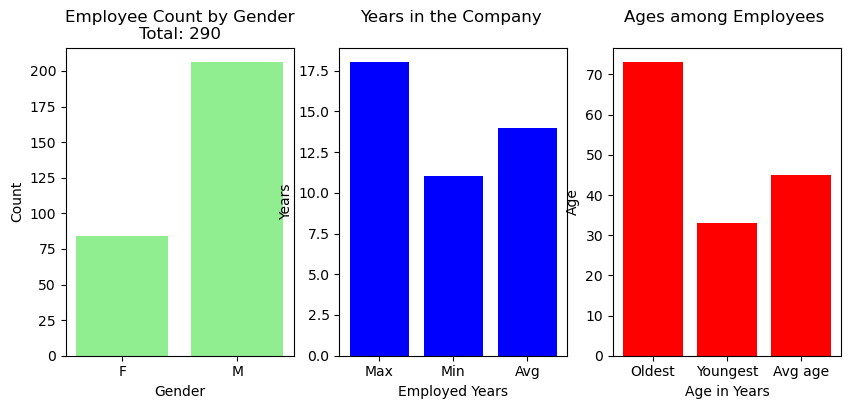

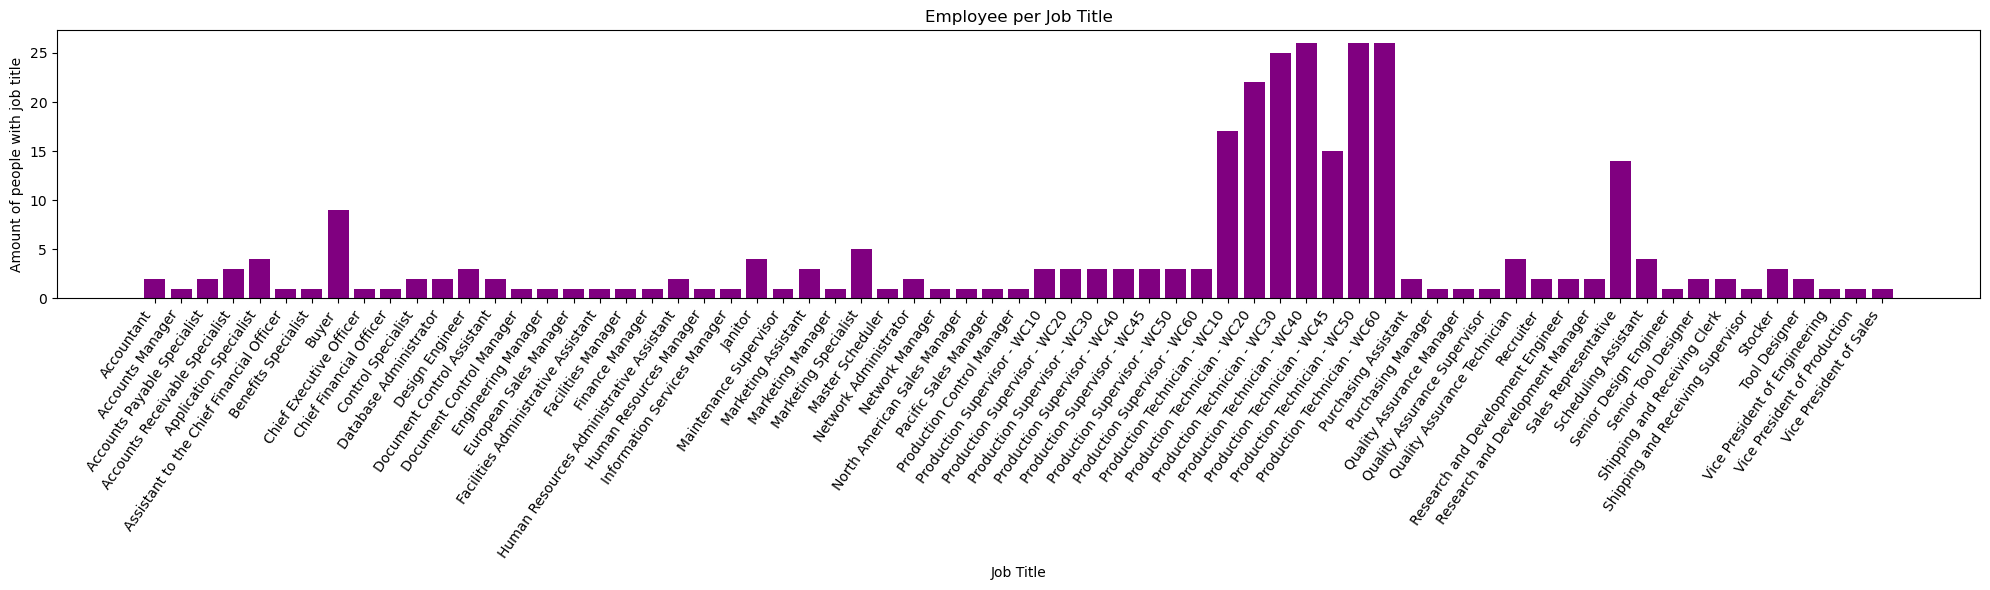

In [32]:
# Extract some info about the company employees.
employee_amount = """
SELECT COUNT(BusinessEntityID) AS Amount,
	Gender
FROM HumanResources.Employee
GROUP BY Gender;
"""

cursor = conn.cursor()
cursor.execute(employee_amount)
results1 = cursor.fetchall()

# Get the data we want by looping
gender = [idx[1] for idx in results1]
count  = [idx[0] for idx in results1]
total  = sum(count)

years_working = """ 
WITH WorkingYearsCTE
AS (
	SELECT 
	  A.JobTitle,
	  A.HireDate, 
	  DATEDIFF(YEAR, HireDate, GETDATE()) AS [Years in the Company]
	FROM HumanResources.Employee A
	JOIN Person.Person B
	ON A.BusinessEntityID = B.BusinessEntityID
 )
 SELECT
  MAX([Years in the Company]) AS [MAX Years],
  MIN([Years in the Company]) AS [MIN Years],
  AVG([Years in the Company]) AS [AVG Years]
 FROM WorkingYearsCTE;
"""

cursor.execute(years_working)
results2 = cursor.fetchone()
years = ['Max','Min','Avg']
amount  = [results2[0], results2[1], results2[2]]

employee_age = """ 
WITH EmployeeYearsCTE
AS (
	SELECT 
	  A.JobTitle,
	  A.BirthDate, 
	  DATEDIFF(YEAR, BirthDate, GETDATE()) AS [Years Old]
	FROM HumanResources.Employee A
	JOIN Person.Person B
	ON A.BusinessEntityID = B.BusinessEntityID
	--ORDER BY [Years in the Company] DESC
 )
 SELECT
  MAX([Years Old]) AS [Oldest Employee],
  MIN([Years Old]) AS [Youngest Employee],
  AVG([Years Old]) AS [Avg age for Employees]
 FROM EmployeeYearsCTE;
"""

cursor.execute(employee_age)
results3 = cursor.fetchone()
ages = ['Oldest','Youngest','Avg age']
age  = [results3[0], results3[1], results3[2]]

jobtitles = """ 
SELECT
    COUNT(BusinessEntityID) AS Amount,
    JobTitle
FROM HumanResources.Employee
GROUP BY JobTitle;
"""

cursor.execute(jobtitles)
results4 = cursor.fetchall()
titles = [idx[1] for idx in results4]
many = [idx[0] for idx in results4]

# Close cursor when we are done
cursor.close()

# Plotting the data
fig, ax = plt.subplots(1,3, figsize=(10, 4))
ax[0].bar(gender, count, color='lightgreen')
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Count')
ax[0].set_title(f'Employee Count by Gender\nTotal: {total}')
ax[1].bar(years, amount, color='Blue')
ax[1].set_xlabel('Employed Years')
ax[1].set_ylabel('Years')
ax[1].set_title(f'Years in the Company \n')
ax[2].bar(ages, age, color='Red')
ax[2].set_xlabel('Age in Years')
ax[2].set_ylabel('Age')
ax[2].set_title(f'Ages among Employees \n')
plt.show()

fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(titles, many, color='Purple')
ax.set_xlabel('Job Title')
ax.set_ylabel('Amount of people with job title')
ax.set_title('Employee per Job Title')

plt.xticks(rotation=55, ha='right')
plt.tight_layout()
plt.show()


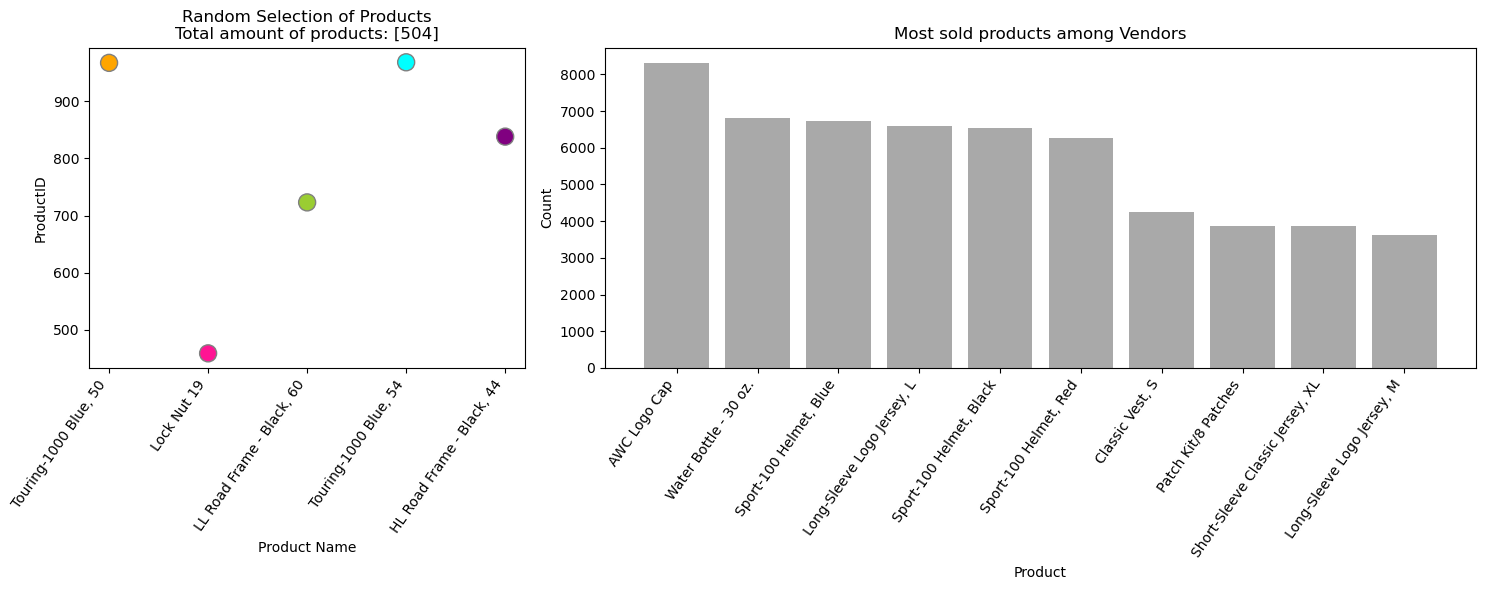

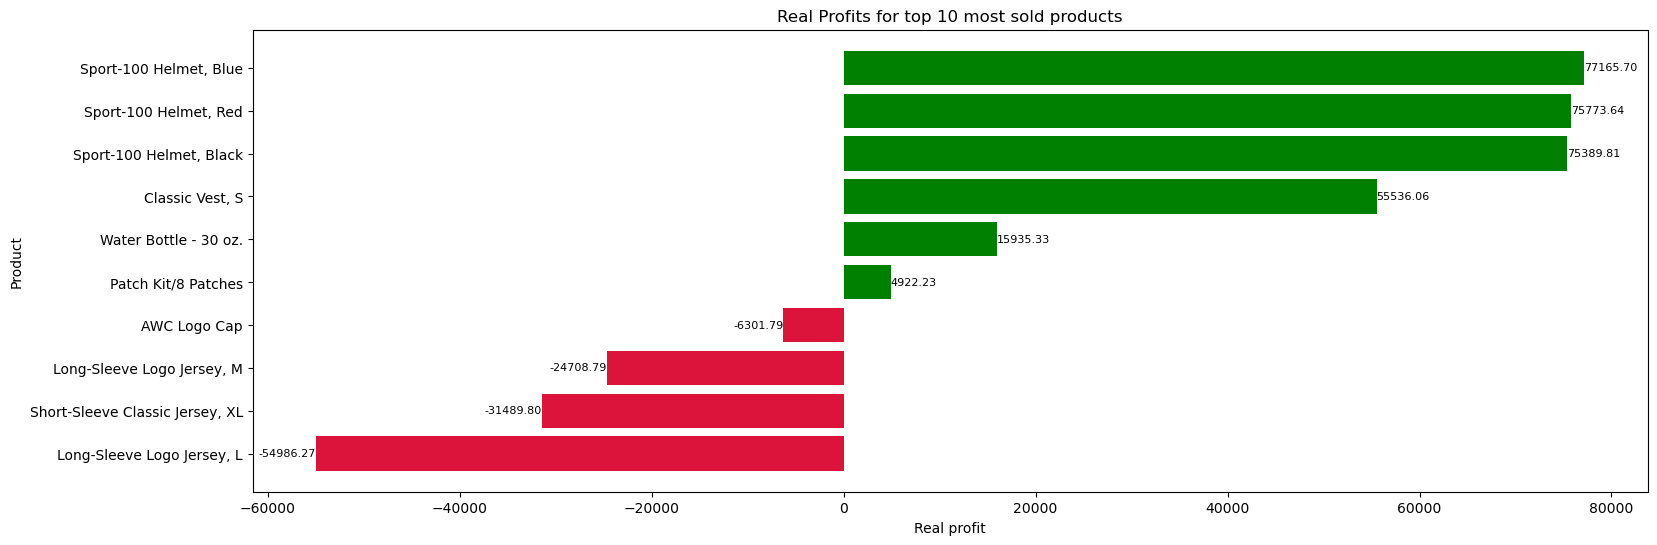

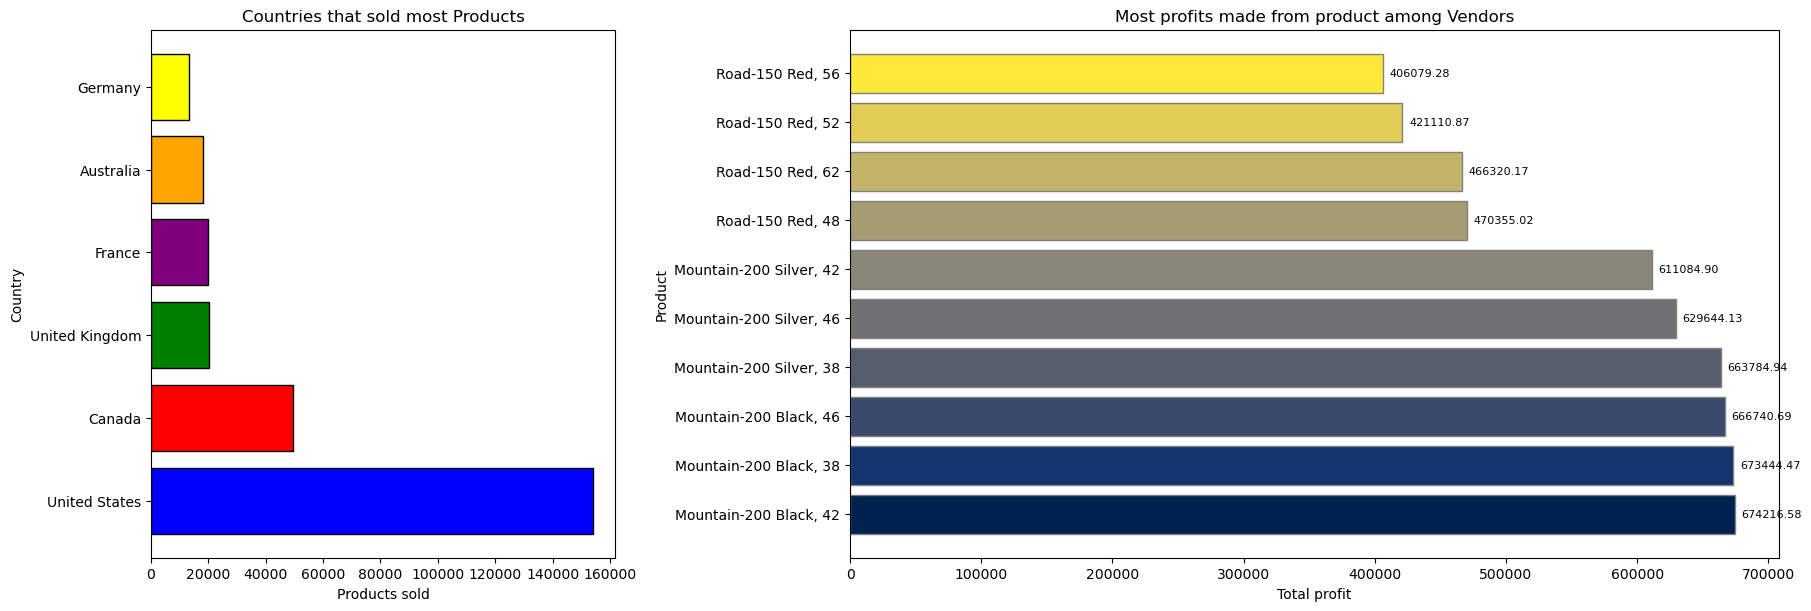

In [56]:
# Information about sold products

# Amount of products
all_products = """SELECT COUNT(ProductID) AS [Amount of Products] FROM Production.Product;"""

cursor = conn.cursor()
cursor.execute(all_products)
results5 = cursor.fetchone()
prodcount = [results5[0]]

# Randomized selection of five products - NEWID is used for unbiased selection
random_prod = """
SELECT TOP 5 
	ProductID, 
	[Name],
	NEWID() AS ID
FROM Production.Product
ORDER BY ID;
"""


cursor.execute(random_prod)
results6 = cursor.fetchall()
pname = [idx[1] for idx in results6]
count  = [idx[0] for idx in results6]
total  = prodcount

# TOP 10 most sold products in Quantity among Vendors
most_sold = """
SELECT TOP 10
    A.Name AS [Name of Product],
    SUM(B.OrderQty) AS TotalSoldQty
FROM Sales.SalesOrderDetail B
JOIN Production.Product A ON B.ProductID = A.ProductID
GROUP BY A.ProductID, A.Name
ORDER BY TotalSoldQty DESC;
"""

cursor.execute(most_sold)
results7 = cursor.fetchall()
prod = [idx[1] for idx in results7]
cnt  = [idx[0] for idx in results7]

# Products that sell well and make profits compared to which ones that doesn't
real_profits = """ 
WITH TopProductsRealProfitsCTE AS (
    SELECT TOP 10
        A.Name AS [Name of Product],
        SUM(B.OrderQty) AS TotalSoldQty
    FROM Sales.SalesOrderDetail B
    JOIN Production.Product A ON B.ProductID = A.ProductID
    GROUP BY A.ProductID, A.Name
    ORDER BY TotalSoldQty DESC
)

SELECT
    A.[Name of Product],
    ROUND(CAST(SUM(B.LineTotal - (B.OrderQty * C.StandardCost)) AS numeric(10, 2)), 2) AS RealProfit
FROM TopProductsRealProfitsCTE A
JOIN Sales.SalesOrderDetail B ON B.ProductID = (SELECT ProductID FROM Production.Product WHERE Name = A.[Name of Product])
JOIN Production.Product C ON B.ProductID = C.ProductID
GROUP BY A.[Name of Product]
ORDER BY RealProfit ASC;
"""
cursor.execute(real_profits)
real = cursor.fetchall()
pnames = [idx[0] for idx in real]
prof  = [idx[1] for idx in real]
#prof = [float(profit) for profit in prof]


# Multi-Joins to find what country sold the most products
country = """ 
SELECT
    E.Name AS Country,
    SUM(A.OrderQty) AS [Sold Products in Total]
FROM
    Sales.SalesOrderDetail A
JOIN Sales.SalesOrderHeader B ON A.SalesOrderID = B.SalesOrderID
JOIN Person.Address C ON B.ShipToAddressID = C.AddressID
JOIN Person.StateProvince D ON C.StateProvinceID = D.StateProvinceID
JOIN Person.CountryRegion E ON D.CountryRegionCode = E.CountryRegionCode
GROUP BY E.Name
ORDER BY [Sold Products in Total] DESC;
"""

cursor.execute(country)
results8 = cursor.fetchall()
cregion = [idx[1] for idx in results8]
cntr  = [idx[0] for idx in results8]

# Top 10 most profit based on quantity and cost among Vendors
most_profit = """
SELECT TOP 10
	A.Name AS [Name of Product],
    ROUND(CAST(SUM(B.LineTotal - (B.OrderQty * A.StandardCost)) AS numeric(18, 2)), 2) AS TotalProfit
FROM Sales.SalesOrderDetail B
JOIN Production.Product A ON B.ProductID = A.ProductID
GROUP BY A.ProductID, A.Name
ORDER BY TotalProfit DESC;
"""

cursor.execute(most_profit)
results9 = cursor.fetchall()
counter  = [idx[0] for idx in results9]
prods = [idx[1] for idx in results9]

# Close cursor when we are done
cursor.close()


## Plots
fig, ax = plt.subplots(1,2,figsize=(15, 6),gridspec_kw={'width_ratios': [1, 2]})
ax[0].scatter(pname, count, s=150,color=['orange','deeppink','yellowgreen','cyan','purple'], edgecolor='gray')
ax[0].set_xlabel('Product Name')
ax[0].set_ylabel('ProductID')
ax[0].set_title(f'Random Selection of Products\nTotal amount of products: {total}')
ax[0].set_xticks(pname)
ax[0].set_xticklabels(pname, rotation=55, horizontalalignment='right')

ax[1].bar(cnt, prod, color='darkgray')
ax[1].set_xlabel('Product')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Most sold products among Vendors')
ax[1].set_xticks(cnt)
ax[1].set_xticklabels(cnt, rotation=55, horizontalalignment='right')
plt.tight_layout()
plt.show()

# Negative profits
fig, ax = plt.subplots(figsize=(18, 6))
colors = ['green' if profit >= 0 else 'crimson' for profit in prof]
bars = ax.barh(pnames, prof, color= colors)
ax.set_xlabel('Real profit')
ax.set_ylabel('Product')
ax.set_title('Real Profits for top 10 most sold products')

# Annotate each bar with its value
for bar, profit in zip(bars, prof):
    ax.text(bar.get_width(), 
            bar.get_y() + bar.get_height() / 2, 
            f'{profit:.2f}',
            va='center', 
            ha='left' if profit >= 0 else 'right', 
            fontsize=8
        )

# Countries and profits
fig, a = plt.subplots(1,2,figsize=(18, 6),layout='constrained', gridspec_kw={'width_ratios': [1, 2]})
a[0].barh(cntr, cregion, color=['blue','red','green','purple','orange','Yellow'], edgecolor='black')
a[0].set_xlabel('Products sold')
a[0].set_ylabel('Country')
a[0].set_title(f'Countries that sold most Products')

gradient = np.linspace(0, 1, len(counter))
bar_colors = plt.cm.cividis(gradient)

bars = a[1].barh(counter, prods, color=bar_colors,edgecolor='gray')
a[1].set_ylabel('Product')
a[1].set_xlabel('Total profit')
a[1].set_title(f'Most profits made from product among Vendors')

#  Annotate
for bar, profit in zip(bars, prods):
    a[1].text( float(profit) + float(5000), 
            bar.get_y() + bar.get_height() / 2, 
            f'{profit:.2f}', 
            va='center', 
            ha='left', 
            fontsize=8
        )

plt.show()


# Analytics segment

In [38]:
# Lets find out what the average difference in price of the most sold model, the "Mountain-200 Black 42", is in France and United Kingdom with a 95% confidence interval
# First we need to make a CTE which shows the sales in France and United Kingdom

most_sold_Fr_UK = """ 
WITH productSalesCTE 
AS (
    SELECT
    E.Name AS Country,
    P.Name,
    A.OrderQty AS [Sold Quantity],
    A.UnitPrice,
    A.LineTotal AS [Price of Sales]
FROM Sales.SalesOrderDetail A
JOIN Sales.SalesOrderHeader B ON A.SalesOrderID = B.SalesOrderID
JOIN Person.Address C ON B.ShipToAddressID = C.AddressID
JOIN Person.StateProvince D ON C.StateProvinceID = D.StateProvinceID
JOIN Person.CountryRegion E ON D.CountryRegionCode = E.CountryRegionCode
JOIN Production.Product P ON A.ProductID = P.ProductID
WHERE P.Name LIKE 'Mountain-200 Black, 42' AND (E.Name = 'France' OR E.Name = 'United Kingdom')
)
"""


# Then we take out the average price from each region
france_num = """
SELECT
    AVG([Price of Sales]) AS AveragePrice
FROM productSalesCTE
WHERE Country = 'France'; 
"""

uk_num = """
SELECT
    AVG([Price of Sales]) AS AveragePrice
FROM productSalesCTE
WHERE Country = 'United Kingdom'; 
"""

# Get all orders with the price of each unit
fr_order = """ 
SELECT 
    [Sold Quantity] AS Quantity,
    UnitPrice
FROM productSalesCTE
WHERE Country = 'France'; 
"""

uk_order = """ 
SELECT 
    [Sold Quantity] AS Quantity,
    UnitPrice
FROM productSalesCTE
WHERE Country = 'United Kingdom'; 
"""

cursor = conn.cursor()

cursor.execute(most_sold_Fr_UK + fr_order)
french_orders = cursor.fetchall()

cursor.execute(most_sold_Fr_UK + uk_order)
uk_orders = cursor.fetchall()

cursor.execute(most_sold_Fr_UK + france_num)
french_avgP = cursor.fetchall()

cursor.execute(most_sold_Fr_UK + uk_num)
UK_avgP = cursor.fetchall()


# Close cursor when we are done
cursor.close()



In [39]:
#Takes in a query with sales figures and an empty array. It then fills the array with unitprices
def fillArray(query,arr):
    for i in range(len(query)):
    
        order = query[i].Quantity
        # This is needed for orders where there are more than one bike
        if(order > 1):
            price = query[i].UnitPrice
            # add each bike order
            for j in range(order):
                arr.append(price)
        else :
            arr.append(query[i].UnitPrice)
    return arr

In [40]:
# To get the standard deviation we need two arrays that are based on the total amount of products sold in each region
fr_arr = []
uk_arr = []
fillArray(french_orders,fr_arr)
fillArray(uk_orders, uk_arr)

# Get the standard deviation
uk_std = round(float(np.std(uk_arr)), 4)
fr_std = round(float(np.std(fr_arr)), 4)

fr_av = round(float(french_avgP[0].AveragePrice), 4)
uk_av = round(float(UK_avgP[0].AveragePrice), 4)

print(fr_std)
print(uk_std)
print(fr_av)
print(uk_av)

422.5014
449.7046
2872.6486
3196.8619


### Now that we have the standard deviation and avg price we can calculate the average difference in price of the most sold model with this formula, with 95% confidence interval
### (avg1 -avg2) + 1.96 * squareroot(power(std1,2)/avg1 + power(std2,2)/avg2)

In [41]:


def av_diff_price(avg1, avg2, std1, std2):
    
    fr = np.power(std1,2) / avg1
    uk = np.power(std2,2) / avg2
    res = 1.96 * np.sqrt(fr + uk)
    mid = round(np.absolute((avg1 - avg2)), 4)
    pos = round(mid + res, 4)
    neg = round(mid - res, 4)
    return pos, neg, mid

num1, num2, m = av_diff_price(fr_av, uk_av, fr_std, uk_std)
print(f"In France and UK, the Avg difference in price for the bike model 'Mountain-200 Black, 42 ' is: \n{m}\n + = {num1}\n - = {num2}")



In France and UK, the Avg difference in price for the bike model 'Mountain-200 Black, 42 ' is: 
324.2133
 + = 346.1619
 - = 302.2647


In [25]:
# Close all connections when we are done
conn.close()